### COVID-19 EDA
Historical data (to 14 December 2020) on the daily number of new reported COVID-19 cases and deaths worldwide.

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import scipy.stats as stats

In [2]:
# save selected figures for report
savefig = False
fig_path = 'mod1_figs/'
if savefig:
    os.makedirs(fig_path, exist_ok=True) 

### Data preparation

In [3]:
# load data; load from source if local copy unavailable
try:
    df0 = pd.read_csv('data.csv')
except FileNotFoundError:    
    data_url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv'
    df0 = pd.read_csv(data_url)
df = df0.copy() # save a copy of the original df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     61900 non-null  object 
 1   day                                                         61900 non-null  int64  
 2   month                                                       61900 non-null  int64  
 3   year                                                        61900 non-null  int64  
 4   cases                                                       61900 non-null  int64  
 5   deaths                                                      61900 non-null  int64  
 6   countriesAndTerritories                                     61900 non-null  object 
 7   geoId                                                       61625 non-null  object 
 

In [4]:
# convert dateRep to datetime
df['dateRep'] = pd.to_datetime(df['dateRep'], format='%d/%m/%Y')

# simplify and shorten column names
df.rename(columns={'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000':'cases_cumsum14_100k',
                   'countriesAndTerritories':'country',
                   'countryterritoryCode':'country_code',
                   'continentExp':'continent'
                   }, inplace=True)

print(f'df shape = {df.shape}')
df.head()

df shape = (61900, 12)


,dateRep,day,month,year,cases,deaths,country,geoId,country_code,popData2019,continent,cases_cumsum14_100k
0,2020-12-14,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,2020-12-13,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,2020-12-12,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,2020-12-11,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,2020-12-10,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


In [5]:
# there are negative entries in cases and deaths; 
# these may be retrospective corrections to the data
print(df[['cases', 'deaths', 'cases_cumsum14_100k']].describe().round(2))
print('')
print('cases with negative values = {:.3f}%'.format(len(df[df['cases']<0])/len(df)*100))
print('deaths with negative values = {:.3f}%'.format(len(df[df['deaths']<0])/len(df)*100))
print('14-day cumsum cases with negative values = {:.3f}%'
      .format(len(df[df['cases_cumsum14_100k']<0])/len(df)*100))
print('')

# because there are relative few negative entries overall, 
# one option for this EDA is to convert these entries to zero
# In any case, removing negative cases and deaths does not affect the overall conclusions
# of this EDA.
if True:
    df.loc[df['cases']<0, 'cases'] = 0
    df.loc[df['deaths']<0, 'deaths'] = 0
    df.loc[df['cases_cumsum14_100k']<0, 'cases_cumsum14_100k'] = 0
    print(df[['cases', 'deaths', 'cases_cumsum14_100k']].describe().round(2))

           cases    deaths  cases_cumsum14_100k
count   61900.00  61900.00             59021.00
mean     1155.15     26.06                66.32
std      6779.22    131.23               162.33
min     -8261.00  -1918.00              -147.42
25%         0.00      0.00                 0.76
50%        15.00      0.00                 6.72
75%       273.00      4.00                52.57
max    234633.00   4928.00              1900.84

cases with negative values = 0.029%
deaths with negative values = 0.013%
14-day cumsum cases with negative values = 0.065%

           cases    deaths  cases_cumsum14_100k
count   61900.00  61900.00             59021.00
mean     1155.41     26.09                66.35
std      6779.08    130.98               162.30
min         0.00      0.00                 0.00
25%         0.00      0.00                 0.76
50%        15.00      0.00                 6.72
75%       273.00      4.00                52.57
max    234633.00   4928.00              1900.84


# of missing values by column:
dateRep                   0
day                       0
month                     0
year                      0
cases                     0
deaths                    0
country                   0
geoId                   275
country_code            123
popData2019             123
continent                 0
cases_cumsum14_100k    2879
dtype: int64


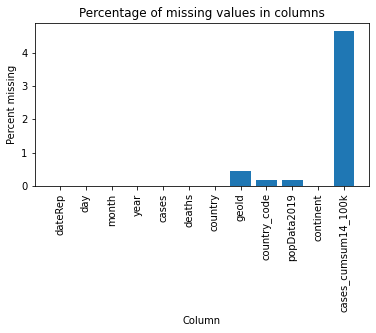

,geoId,country_code,popData2019
country,,,
Cases_on_an_international_conveyance_Japan,0,64,64
Namibia,275,0,0
Wallis_and_Futuna,0,59,59


In [6]:
# missing values
print('# of missing values by column:')
print(df.isna().sum())

# percentage of missing values by columns
pct_missing_col = df.isna().sum()/len(df)*100
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(pct_missing_col.index, pct_missing_col)
ax.set_ylabel('Percent missing')
ax.set_xlabel('Column')
ax.set_title('Percentage of missing values in columns')
plt.xticks(rotation=90)
plt.show()

# which countries are missing data?
df_missing = df.set_index('country').isna().sum(level=0)[df.columns[df.isna().sum()>0].to_list()[:-1]]
df_missing[(df_missing>0).any(1)]

In [7]:
# assign a geoId for Namibia
df.loc[df['country']=='Namibia', 'geoId'] = 'NA'

# Wallis_and_Futuna has a total of 3 cases and 0 deaths, will exclude from EDA
print('# cases and # deaths for Wallis_and_Futuna')
print(df[df['country']=='Wallis_and_Futuna'][['cases', 'deaths']].sum())
df = df[df['country']!='Wallis_and_Futuna'].reset_index(drop=True)

# 'Cases_on_an_international_conveyance_Japan' has a total of 696 cases and 7 deaths, will exclude from EDA
# because the exact countries of origin are not available in the data
print('\n# cases and # deaths for Cases_on_an_international_conveyance_Japan')
print(df[df['country']=='Cases_on_an_international_conveyance_Japan'][['cases', 'deaths']].sum())
df = df[df['country']!='Cases_on_an_international_conveyance_Japan'].reset_index(drop=True)

print('\n# of missing values by column, after data preparation/cleaning:')
print(df.isna().sum()) # no missing values (except for dates where there were no 14-day summmed cases)

print(f'\ndf shape = {df.shape}')
df.head()

# cases and # deaths for Wallis_and_Futuna
cases     3
deaths    0
dtype: int64

# cases and # deaths for Cases_on_an_international_conveyance_Japan
cases     705
deaths      7
dtype: int64

# of missing values by column, after data preparation/cleaning:
dateRep                   0
day                       0
month                     0
year                      0
cases                     0
deaths                    0
country                   0
geoId                     0
country_code              0
popData2019               0
continent                 0
cases_cumsum14_100k    2756
dtype: int64

df shape = (61777, 12)


,dateRep,day,month,year,cases,deaths,country,geoId,country_code,popData2019,continent,cases_cumsum14_100k
0,2020-12-14,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,2020-12-13,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,2020-12-12,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,2020-12-11,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,2020-12-10,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


In [8]:
# check correspondence of geoId, country, country_code
print('unique values for geographical identifers:')
print(df[['country', 'geoId', 'country_code']].nunique())

def check_correspond(df, col1, col2):
    # function to check correspondence
    return df.groupby(col1)[col2].apply(lambda x: x.nunique()==1).all()

assert check_correspond(df, 'country', 'geoId')
assert check_correspond(df, 'country', 'country_code')
assert check_correspond(df, 'geoId', 'country_code')
# country, geoId, country_code have one-to-one correspondence

unique values for geographical identifers:
country         212
geoId           212
country_code    212
dtype: int64


In [9]:
# find duplicated rows
print(f'Original number of rows: {len(df)}')
print(f'Number of duplicate rows (all duplicates): \
{df.duplicated(keep=False).sum()} or {df.duplicated(keep=False).sum()/len(df)*100:.2f}%')
print(f'Number of duplicate rows (not counting first occurrence): \
{df.duplicated().sum()} or {df.duplicated().sum()/len(df)*100:.2f}%')

Original number of rows: 61777
Number of duplicate rows (all duplicates): 0 or 0.00%
Number of duplicate rows (not counting first occurrence): 0 or 0.00%


### Data exploration

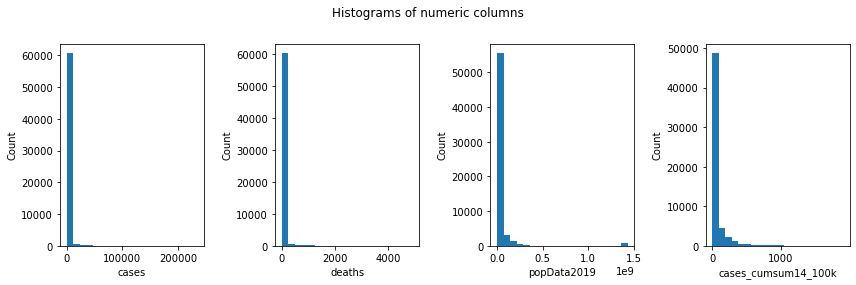

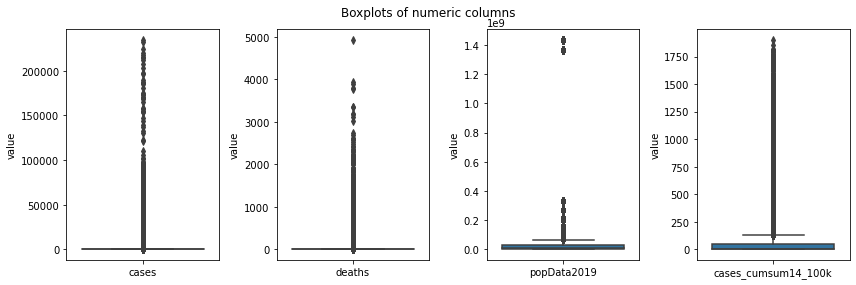

In [10]:
# visualize distribution and outliers with histograms and boxplots
# plot numeric columns of the entire df
num_cols = df.columns[(df.dtypes=='float64') | (df.dtypes=='int64')].tolist()
num_cols = [xx for xx in num_cols if xx not in ['day', 'month', 'year']]

fig, axs = plt.subplots(1, len(num_cols), figsize=(len(num_cols)*3,4))
for ii, xx in enumerate(num_cols):
    axs[ii].hist(df[xx], bins=20)
    axs[ii].set(xlabel=xx, ylabel='Count')
plt.suptitle('Histograms of numeric columns')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

fig, axs = plt.subplots(1, len(num_cols), figsize=(len(num_cols)*3,4))
for ii, xx in enumerate(num_cols):
    sns.boxplot(x='variable', y='value', data=pd.melt(df[[xx]]), ax=axs[ii])
    axs[ii].set(xlabel='')
plt.suptitle('Boxplots of numeric columns')
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

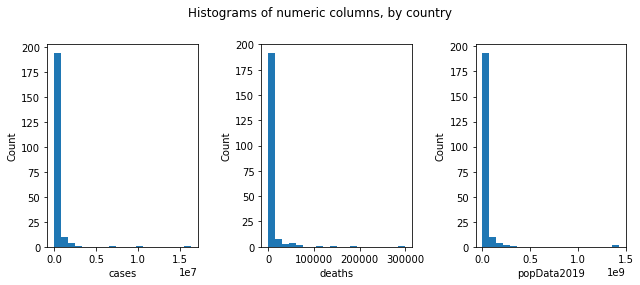

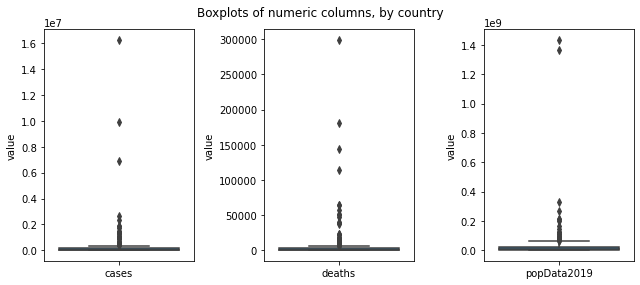


 cases
iqr = 145481.8
Fraction of outliers = 14.6%

 deaths
iqr = 2520.5
Fraction of outliers = 16.5%

 popData2019
iqr = 24461891.5
Fraction of outliers = 10.4%


In [11]:
# visualize distribution of outliers with histograms and boxplots
# aggregate by country
df_tmp = df.groupby('country').agg({'cases':'sum', 'deaths':'sum', 'popData2019':'max'})#.reset_index()
num_cols = df_tmp.columns

fig, axs = plt.subplots(1, len(num_cols), figsize=(len(num_cols)*3,4))
for ii, xx in enumerate(num_cols):
    axs[ii].hist(df_tmp[xx], bins=20)
    axs[ii].set(xlabel=xx, ylabel='Count')
plt.suptitle('Histograms of numeric columns, by country')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

fig, axs = plt.subplots(1, len(num_cols), figsize=(len(num_cols)*3,4))
for ii, xx in enumerate(num_cols):
    sns.boxplot(x='variable', y='value', data=pd.melt(df_tmp[[xx]]), ax=axs[ii])
    axs[ii].set(xlabel='')
plt.suptitle('Boxplots of numeric columns, by country')
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# get stats on outliers by IQR threshold (Q1-1.5*IQR; Q3+1.5*IQR)
# However, for timeseries such as daily cases and deaths, it might be better to use methods 
# such as STL decomposition or ARIMA models to evaluate outliers
for ii, xx in enumerate(num_cols):
    print('\n',xx)
#     print('q1 = {:.1f}'.format(boxplot_stats(df_tmp)[ii]['q1']))
#     print('median = {:.1f}'.format(boxplot_stats(df_tmp)[ii]['med']))
#     print('q3 = {:.1f}'.format(boxplot_stats(df_tmp)[ii]['q3']))
    print('iqr = {:.1f}'.format(boxplot_stats(df_tmp)[ii]['iqr']))
    print('Fraction of outliers = {:.1f}%'
          .format(len(boxplot_stats(df_tmp)[ii]['fliers'])/df_tmp[xx].count()*100))

In [12]:
# examine the categorical variables
df.describe(include=['O'])

,country,geoId,country_code,continent
count,61777,61777,61777,61777
unique,212,212,212,5
top,Iran,RU,FRA,Europe
freq,350,350,350,17372


In [13]:
# feature creation: rates per 100k population 
# (to be consistent with provided/existing 14-day cumsum per 100k population)
df['cases_100k'] = df['cases']/df['popData2019']*100000
df['deaths_100k'] = df['deaths']/df['popData2019']*100000

# feature creation: year/month to examine data by month
df['year_month'] = list(zip(df['year'], df['month']))
# print(df['year_month'].value_counts())

# feature creation: day of the week to explore daily fluctuations in reporting (weekly periodicity)
df['dayofweek'] = df['dateRep'].dt.dayofweek.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
df['dayofweek'] = pd.Categorical(df['dayofweek'], ordered=True, 
                                 categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
# print(df['dayofweek'].value_counts())

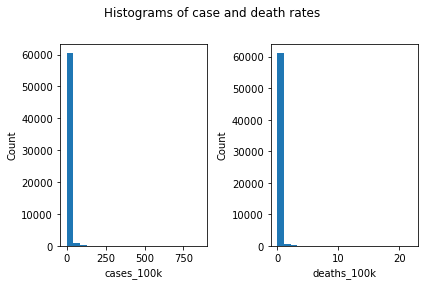

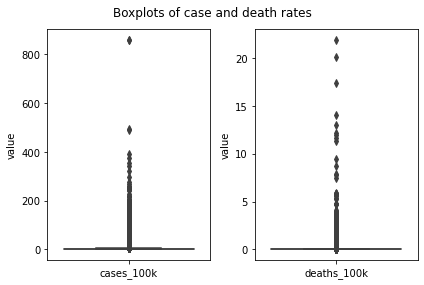

In [14]:
# histograms and boxplots of the case rates and death rates
num_cols = ['cases_100k', 'deaths_100k']

fig, axs = plt.subplots(1, len(num_cols), figsize=(6,4))
for ii, xx in enumerate(num_cols):
    axs[ii].hist(df[xx], bins=20)
    axs[ii].set(xlabel=xx, ylabel='Count')
plt.suptitle('Histograms of case and death rates')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

fig, axs = plt.subplots(1, len(num_cols), figsize=(6,4))
for ii, xx in enumerate(num_cols):
    sns.boxplot(x='variable', y='value', data=pd.melt(df[[xx]]), ax=axs[ii])
    axs[ii].set(xlabel='')
plt.suptitle('Boxplots of case and death rates')
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Data scaling and comparisons


after min-max scaling:
      cases_minmax  deaths_minmax
min           0.0            0.0
max           1.0            1.0

after standard scaling:
       cases_standard  deaths_standard
mean        0.000000    -2.576389e-17
std         1.000008     1.000008e+00


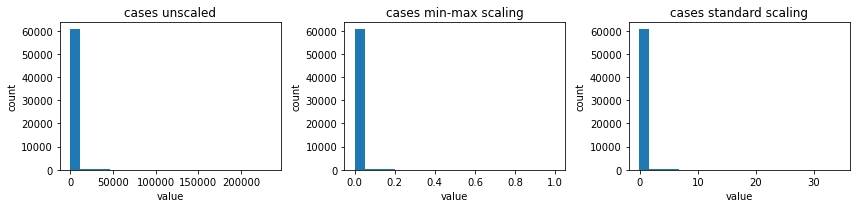

In [15]:
# select variable of meaningful magnitude and perform both min-max and standard scaling
# scale 'cases' and 'deaths' of the entire df
cols2scale = ['cases', 'deaths']
features2scale = df.copy()[cols2scale]

# min-max scaling
minmax_scaler = MinMaxScaler().fit(features2scale)
cols_scaled = [xx+'_minmax' for xx in cols2scale]
df[cols_scaled] = minmax_scaler.transform(features2scale)
# check inverse transform
assert np.all(minmax_scaler.inverse_transform(df[cols_scaled]).round(3)==
              df[cols2scale].to_numpy().round(3))

# standard scaling
standard_scaler = StandardScaler().fit(features2scale)
cols_scaled = [xx+'_standard' for xx in cols2scale]
df[cols_scaled] = standard_scaler.transform(features2scale)
# check inverse transform
assert np.all(standard_scaler.inverse_transform(df[cols_scaled]).round(3)==
              df[cols2scale].to_numpy().round(3))

print('\nafter min-max scaling:\n', df[['cases_minmax', 'deaths_minmax']]
      .agg(['min', 'max'])) # min=0, max=1
print('\nafter standard scaling:\n', df[['cases_standard', 'deaths_standard']]
      .agg(['mean', 'std'])) # mean=0, std=1

# histogram of cases before and after scaling
fig, axs = plt.subplots(1,3, figsize=(12,3))
axs[0].hist(df['cases'], bins=20)
axs[1].hist(df['cases_minmax'], bins=20)
axs[2].hist(df['cases_standard'], bins=20)
axs[0].set(title='cases unscaled')
axs[1].set(title='cases min-max scaling')
axs[2].set(title='cases standard scaling')
for ax in axs:
    ax.set(xlabel='value', ylabel='count')
fig.tight_layout()
plt.show()

In [16]:
# function to get bivariate plots of cases and deaths before and after scaling
def plot_bivariate(df2plot, dfname):
    for (xx, yy) in list(zip(['cases', 'cases_minmax', 'cases_standard'], 
                             ['deaths', 'deaths_minmax', 'deaths_standard'])):
        rr, pp = stats.pearsonr(df2plot[xx], df2plot[yy])
        g = sns.jointplot(data=df2plot, x=xx, y=yy, alpha=0.8,
                          marginal_kws=dict(bins=20))
        g.set_axis_labels('cases', 'deaths')
        g.ax_joint.grid()
        g.ax_joint.annotate(f'r={rr:.2f}, p={pp:.2f}',
                            xy=(0.1, 0.9), xycoords='axes fraction',
                            ha='left', va='center')
        if xx=='cases':
            transform = 'unscaled data'
            panel = 'B'
        elif xx=='cases_minmax':
            transform = 'data after min-max scaling'
            panel = 'C'
        elif xx=='cases_standard':
            transform = 'data after standard scaling'
            panel = 'D'
        if dfname=='agg':
            g.fig.suptitle(f'Fig. 6{panel}. Total daily # deaths vs. total daily # cases\n{transform}')
        else:
            g.fig.suptitle(f'# deaths vs. # cases from entire dataframe\n{transform}')
        plt.tight_layout()
        plt.show()
        if savefig:
            g.fig.savefig(fig_path+dfname+'_'+xx+'.pdf', bbox_inches='tight')

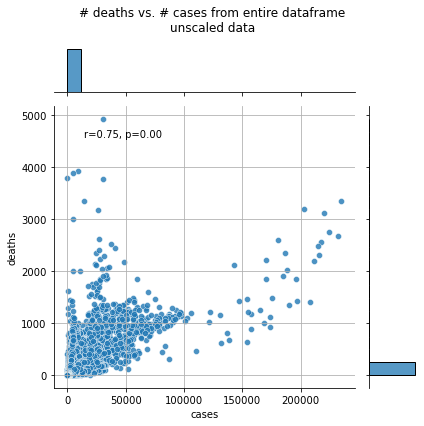

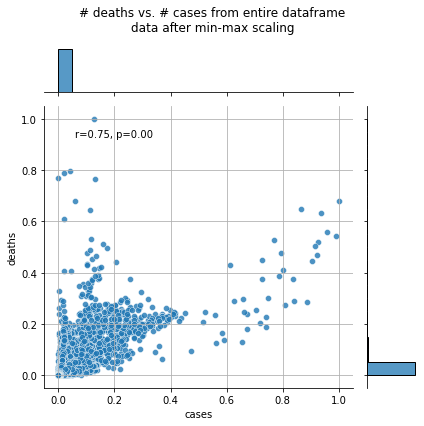

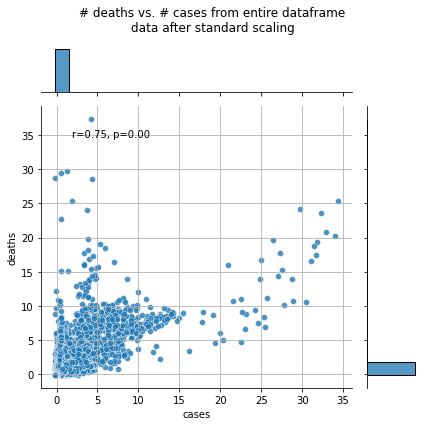

In [17]:
# plot bivariate deaths vs. cases for orignal df
plot_bivariate(df2plot=df, dfname='orig')


after min-max scaling:
      cases_minmax  deaths_minmax
min           0.0            0.0
max           1.0            1.0

after standard scaling:
       cases_standard  deaths_standard
mean        0.000000     8.120488e-17
std         1.001432     1.001432e+00


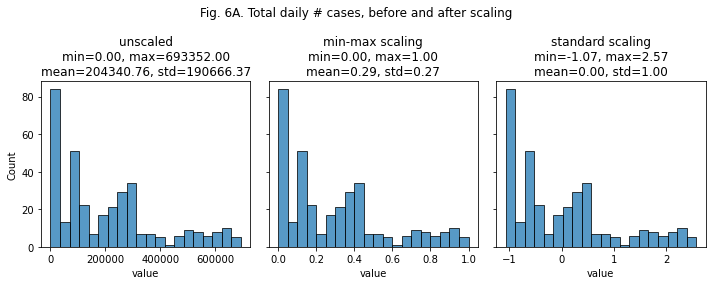

In [18]:
# Since both min-max and standard scaling were sensitive to the presence of outliers, 
# min-max and standard scaling were also performed on total daily number of cases and deaths 
# (cases and deaths aggregated by the reporting date and summed) in a separate df. 
# The fewer number of extreme outliers in the aggregated data frame made it easier 
# to visualize results of the scaling transformations.
df_scaling = df.copy().groupby('dateRep')[['cases', 'deaths']].sum().reset_index()

cols2scale = ['cases', 'deaths']
features2scale = df_scaling[cols2scale]

# min-max scaling
minmax_scaler2 = MinMaxScaler().fit(features2scale)
cols_scaled = [xx+'_minmax' for xx in cols2scale]
df_scaling[cols_scaled] = minmax_scaler2.transform(features2scale)
# check inverse transform
assert np.all(minmax_scaler2.inverse_transform(df_scaling[cols_scaled]).round(3)==
              df_scaling[cols2scale].to_numpy().round(3))

# standard scaling
standard_scaler2 = StandardScaler().fit(features2scale)
cols_scaled = [xx+'_standard' for xx in cols2scale]
df_scaling[cols_scaled] = standard_scaler2.transform(features2scale)
# check inverse transform
assert np.all(standard_scaler2.inverse_transform(df_scaling[cols_scaled]).round(3)==
              df_scaling[cols2scale].to_numpy().round(3))

print('\nafter min-max scaling:\n', df_scaling[['cases_minmax', 'deaths_minmax']]
      .agg(['min', 'max'])) # min=0, max=1
print('\nafter standard scaling:\n', df_scaling[['cases_standard', 'deaths_standard']]
      .agg(['mean', 'std'])) # mean=0, std=1

# plot univariate (# cases) before and after scaliing
fig, axs = plt.subplots(1,3, figsize=(10, 4), sharey=True)
sns.histplot(df_scaling['cases'], bins=20, ax=axs[0])
sns.histplot(df_scaling['cases_minmax'], bins=20, ax=axs[1])
sns.histplot(df_scaling['cases_standard'], bins=20, ax=axs[2])
plt.suptitle('Fig. 6A. Total daily # cases, before and after scaling')
axs[0].set(title='unscaled\nmin={:.2f}, max={:.2f}\nmean={:.2f}, std={:.2f}'
           .format(df_scaling['cases'].min(), 
                   df_scaling['cases'].max(), 
                   df_scaling['cases'].mean(), 
                   df_scaling['cases'].std()), 
           xlabel='value')
axs[1].set(title='min-max scaling\nmin={:.2f}, max={:.2f}\nmean={:.2f}, std={:.2f}'
           .format(df_scaling['cases_minmax'].min(),
                   df_scaling['cases_minmax'].max(), 
                   df_scaling['cases_minmax'].mean(), 
                   df_scaling['cases_minmax'].std()), 
           xlabel='value')
axs[2].set(title='standard scaling\nmin={:.2f}, max={:.2f}\nmean={:.2f}, std={:.2f}'
           .format(df_scaling['cases_standard'].min(), 
                   df_scaling['cases_standard'].max(), 
                   df_scaling['cases_standard'].mean(), 
                   df_scaling['cases_standard'].std()), 
           xlabel='value')
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'grouped_cases_transform.pdf', bbox_inches='tight')

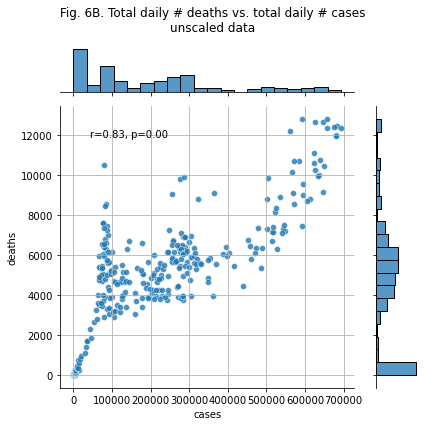

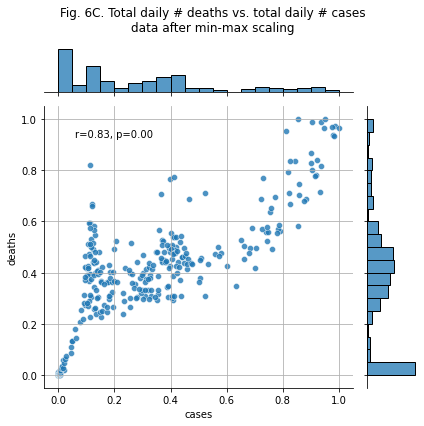

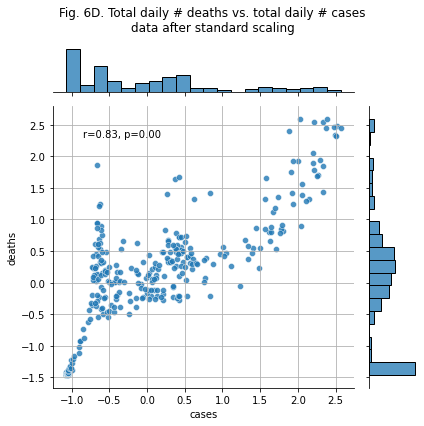

In [19]:
# plot bivariate total daily deaths vs. total daily cases (df summed by date)
plot_bivariate(df2plot=df_scaling, dfname='agg')

### Data exploration continued

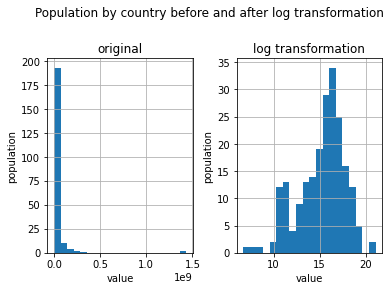

In [20]:
# From the assignment background information: 
# "It is often best to use scaling methods that preserve the shape of the distribution. 
# But if there are extreme outliers or heavily skewed distributions, 
# then log or normalizing transformations may be warranted"

# test the effect of log transformation on population data by country, 
# which has extreme outliers and a heavily skewed distribution

# histograms of the population data by country before and after log transformation
df['pop_log'] = np.log(df['popData2019'])
df_tmp = df.groupby('country')[['popData2019', 'pop_log']].max()
axs = df_tmp.hist(bins=20);
plt.suptitle('Population by country before and after log transformation');
for ax in axs[0]:
    ax.set(xlabel='value', ylabel='population')
axs[0][0].set_title('original')
axs[0][1].set_title('log transformation')
plt.subplots_adjust(top=0.8)
plt.show()
# the log transformation could be useful for subsequent analyses as the log-transformed distribution 
# appears less skewed, potentially making data patterns more discernable

In [21]:
# descriptive statistics on variables with meaningful magnitudes
# overall/entire df
print('Overall cases:')
print(df[['cases', 'cases_100k', 'cases_cumsum14_100k']].describe().round(2))

print('\nDeaths overall:')
print(df[['deaths', 'deaths_100k']].describe().round(2))

Overall cases:
           cases  cases_100k  cases_cumsum14_100k
count   61777.00    61777.00             59021.00
mean     1157.70        4.85                66.35
std      6785.64       14.93               162.30
min         0.00        0.00                 0.00
25%         0.00        0.00                 0.76
50%        16.00        0.26                 6.72
75%       276.00        3.12                52.57
max    234633.00      858.90              1900.84

Deaths overall:
         deaths  deaths_100k
count  61777.00     61777.00
mean      26.15         0.08
std      131.11         0.32
min        0.00         0.00
25%        0.00         0.00
50%        0.00         0.00
75%        4.00         0.03
max     4928.00        21.87


In [22]:
# by month
print('Cases by month:')
print(df.groupby(['year', 'month'])[['cases', 'cases_100k']].agg(['count', 'mean', 'std']).round(2))

print('\nDeaths by month:')
print(df.groupby(['year', 'month'])[['deaths', 'deaths_100k']].agg(['count', 'mean', 'std']).round(2))

Cases by month:
           cases                    cases_100k              
           count     mean       std      count   mean    std
year month                                                  
2019 12       66     0.41      3.32         66   0.00   0.00
2020 1      2046     4.79     81.30       2046   0.00   0.01
     2      1914    39.04    443.07       1914   0.01   0.12
     3      3850   187.99   1021.68       3850   1.62   9.87
     4      6125   382.11   2199.88       6125   1.89   6.31
     5      6464   448.15   2137.40       6464   1.61   5.34
     6      6269   678.01   3179.09       6269   2.13   6.21
     7      6479  1090.85   5824.01       6479   2.93   6.31
     8      6479  1229.39   6394.60       6479   3.99   8.94
     9      6270  1350.00   7134.80       6270   4.78  10.53
     10     6498  1838.88   7100.43       6498   9.13  26.22
     11     6350  2698.27  11707.56       6350  13.20  25.20
     12     2967  2912.99  15044.17       2967  13.42  23.58

Deaths 

In [23]:
# daily, 10 days with the most # cases and # deaths
print('Cases by day (top 10 days with most cases):')
print(df.groupby('dateRep')[['cases', 'cases_100k']]
      .agg(['count', 'mean', 'std']).sort_values(by=('cases', 'mean'))[::-1][:10].round(2))

print('\nDeaths by day (top 10 days with most deaths):')
print(df.groupby('dateRep')[['deaths', 'deaths_100k']]
      .agg(['count', 'mean', 'std']).sort_values(by=('deaths', 'mean'))[::-1][:10].round(2))

Cases by day (top 10 days with most cases):
           cases                    cases_100k              
           count     mean       std      count   mean    std
dateRep                                                     
2020-12-11   212  3270.53  16431.55        212  14.97  23.91
2020-12-05   212  3223.41  16857.81        212  14.84  25.26
2020-12-04   212  3212.78  15809.30        212  16.61  34.05
2020-11-21   212  3203.99  14808.01        212  15.24  26.17
2020-12-10   212  3189.22  16105.40        212  14.90  25.00
2020-12-03   212  3102.44  15015.89        212  14.41  23.92
2020-12-12   212  3099.72  16984.95        212  15.58  26.81
2020-11-28   212  3063.08  15234.93        212  15.24  28.45
2020-11-26   212  3056.04  14055.96        212  14.78  25.97
2020-11-13   212  3054.25  12249.84        212  15.62  25.54

Deaths by day (top 10 days with most deaths):
           deaths                deaths_100k            
            count   mean     std       count  mean   std
da

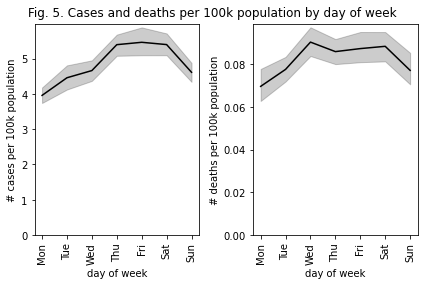

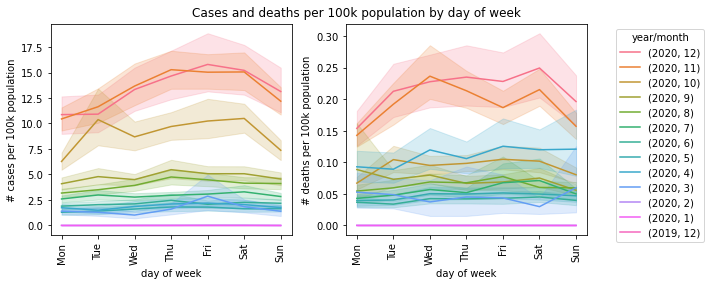

cases and deaths by day of week:


cases                   cases_100k        deaths                 \
          count     mean      std       mean    std  count   mean     std   
dayofweek                                                                   
Mon        8896  1061.27  6158.98       3.96  10.57   8896  19.72   94.76   
Tue        8739   983.61  5863.59       4.46  17.17   8739  20.58   89.34   
Wed        8772  1126.68  6570.90       4.66  14.23   8772  29.56  144.88   
Thu        8797  1234.24  7048.79       5.39  15.51   8797  29.73  152.64   
Fri        8834  1256.31  7074.40       5.46  17.86   8834  30.32  159.62   
Sat        8858  1262.52  7616.78       5.40  15.38   8858  28.36  140.32   
Sun        8881  1177.79  6994.08       4.61  12.45   8881  24.79  117.54   

          deaths_100k        
                 mean   std  
dayofweek                    
Mon              0.07  0.35  
Tue              0.08  0.28  
Wed              0.09  0.33  
Thu              0.09  0.28  
Fri              0.09  0.34  
Sat              0.09  0.32  
Sun              0.08  0.36

In [24]:
# cases and deaths by day of week
fig, axs = plt.subplots(1,2)
sns.lineplot(x='dayofweek', y='cases_100k', data=df, color='k', ax=axs[0])
sns.lineplot(x='dayofweek', y='deaths_100k', data=df, color='k', ax=axs[1])
axs[0].set_ylabel('# cases per 100k population')
axs[1].set_ylabel('# deaths per 100k population')
for ax in axs:
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('day of week')
    ax.set_ylim([0, None])
fig.tight_layout()
plt.suptitle('Fig. 5. Cases and deaths per 100k population by day of week')
plt.subplots_adjust(top=0.92)
plt.show()
if savefig:
    fig.savefig(fig_path+'cases_deaths_dayofweek.pdf', bbox_inches='tight')

fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.lineplot(x='dayofweek', y='cases_100k', hue='year_month', data=df, ax=axs[0])
sns.lineplot(x='dayofweek', y='deaths_100k', hue='year_month', data=df, ax=axs[1])
axs[0].legend().remove()
axs[1].legend(bbox_to_anchor=(1.1, 1), title='year/month')
axs[0].set_ylabel('# cases per 100k population')
axs[1].set_ylabel('# deaths per 100k population')
for ax in axs:
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('day of week')
fig.tight_layout()
plt.suptitle('Cases and deaths per 100k population by day of week')
plt.subplots_adjust(top=0.92)
plt.show()

print('cases and deaths by day of week:')
df.groupby('dayofweek').agg({'cases':['count', 'mean', 'std'],
                             'cases_100k':['mean', 'std'],
                             'deaths':['count', 'mean', 'std'], 
                             'deaths_100k':['mean', 'std'],
                            }).round(2)

In [25]:
# cases and deaths by year/month
print('cases and deaths by year/month:')
df.groupby('year_month')[['cases_100k', 'deaths_100k']].agg(['sum', 'mean', 'std']).round(2)

cases and deaths by year/month:


cases_100k               deaths_100k            
                  sum   mean    std         sum  mean   std
year_month                                                 
(2019, 12)       0.00   0.00   0.00        0.00  0.00  0.00
(2020, 1)        1.15   0.00   0.01        0.01  0.00  0.00
(2020, 2)       25.79   0.01   0.12        0.30  0.00  0.00
(2020, 3)     6225.71   1.62   9.87      177.23  0.05  0.42
(2020, 4)    11578.77   1.89   6.31      677.33  0.11  0.50
(2020, 5)    10390.95   1.61   5.34      304.31  0.05  0.15
(2020, 6)    13377.50   2.13   6.21      250.94  0.04  0.12
(2020, 7)    19008.23   2.93   6.31      361.36  0.06  0.25
(2020, 8)    25876.73   3.99   8.94      410.28  0.06  0.22
(2020, 9)    29979.60   4.78  10.53      456.07  0.07  0.38
(2020, 10)   59338.31   9.13  26.22      609.88  0.09  0.26
(2020, 11)   83794.51  13.20  25.20     1200.08  0.19  0.44
(2020, 12)   39808.12  13.42  23.58      636.51  0.21  0.44

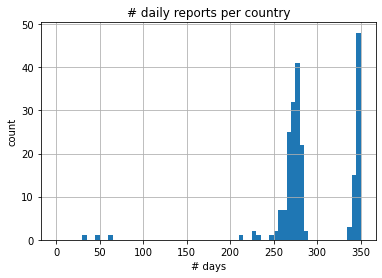

# reports by country:
count    212.0
mean     291.4
std       46.5
min       34.0
25%      270.0
50%      276.0
75%      343.0
max      350.0
Name: dateRep, dtype: float64


In [26]:
# number of daily reports by country
fig, ax = plt.subplots()
df.groupby('country')['dateRep'].count().hist(bins=range(0, 355, 5), ax=ax)
ax.set_title('# daily reports per country')
ax.set(title='# daily reports per country', xlabel='# days', ylabel='count')
plt.show()
print('# reports by country:')
print(df.groupby('country')['dateRep'].count().describe().round(1))

### Analysis: How is the world affected? <br>Time series of # cases and # deaths worldwide<br> Correlation between between cases vs. date and deaths vs. date

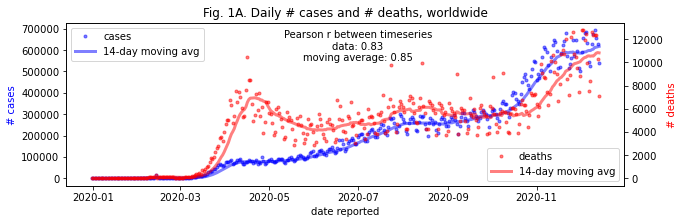

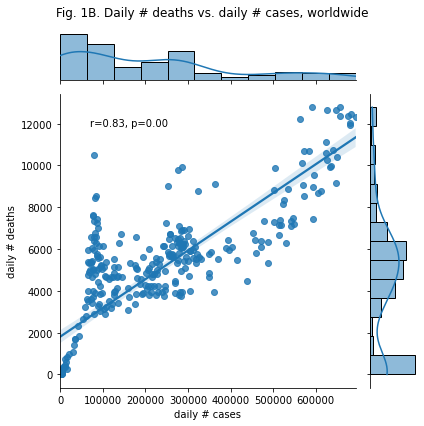

In [27]:
df_tmp = df.groupby('dateRep')[['cases', 'deaths']].sum()
# plotting a moving average may reduce some day-to-day variations in reporting
# n-day moving average and n-day moving average per 100k for cases and deaths
dd = 14 # number of days for moving average

# feature creation: moving average # cases and # deaths
df_tmp2 = df_tmp.rolling(window=dd).mean()
cc = df_tmp[['cases', 'deaths']].corr().loc['cases', 'deaths']
cc2 = df_tmp2[['cases', 'deaths']].corr().loc['cases', 'deaths']
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df_tmp.index, df_tmp['cases'], 'ob', ms=3, alpha=0.5, label='cases')
ax.plot(df_tmp2.index, df_tmp2['cases'], '-b', lw=3, alpha=0.5, label=f'{dd}-day moving avg')
ax1 = ax.twinx()
ax1.plot(df_tmp.index, df_tmp['deaths'], 'or', ms=3, alpha=0.5, label='deaths')
ax1.plot(df_tmp2.index, df_tmp2['deaths'], '-r', lw=3, alpha=0.5, label=f'{dd}-day moving avg')
ax.legend(loc=2)
ax1.legend(loc=4)
ax.set_ylabel('# cases', c='b')
ax.set(xlabel='date reported', title='Fig. 1A. Daily # cases and # deaths, worldwide')
ax1.set_ylabel('# deaths', c='r')
ax.text(pd.Timestamp('2020-07-01'), 550000, 
        s=f'Pearson r between timeseries\ndata: {cc:.2f}\nmoving average: {cc2:.2f}',
        ha='center')
plt.show()
if savefig:
    fig.savefig(fig_path+'daily_cases_deaths_vs_time.pdf', bbox_inches='tight')

rr, pp = stats.pearsonr(df_tmp['cases'], df_tmp['deaths'])
g = sns.jointplot(data=df_tmp, x='cases', y='deaths', kind='reg')
g.set_axis_labels('daily # cases', 'daily # deaths')
g.ax_joint.annotate(f'r={rr:.2f}, p={pp:.2f}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center')
g.fig.suptitle('Fig. 1B. Daily # deaths vs. daily # cases, worldwide')
plt.tight_layout()
plt.show()
if savefig:
    g.fig.savefig(fig_path+'daily_cases_vs_deaths.pdf', bbox_inches='tight')

### Analysis: How are different continents affected?<br>Moving average of reported # cases and # deaths by continent

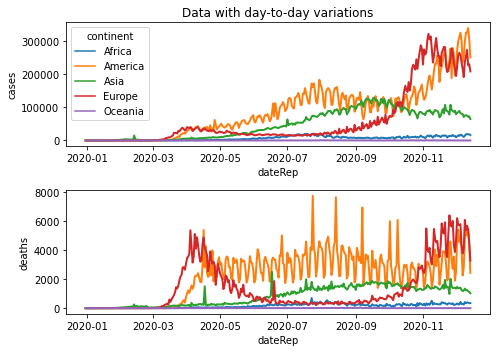

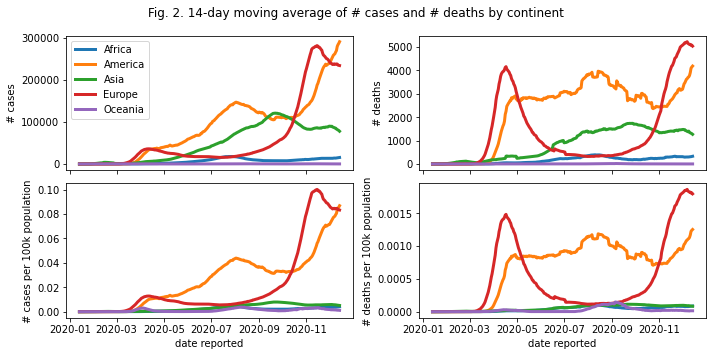

Pearson r between daily cases and daily deaths by continent:


,continent,r-value,p-value
0,Africa,0.898,0.0
1,America,0.730,0.0
2,Asia,0.960,0.0
3,Europe,0.739,0.0
4,Oceania,0.394,0.0


In [28]:
df_tmp = df.copy()
df_tmp = df_tmp.groupby(['dateRep', 'continent'])[['cases', 'deaths']].sum().reset_index()
# plot cases and deaths vs. time by continent
fig, axs = plt.subplots(2, 1, figsize=(7,5))
sns.lineplot(x='dateRep', y='cases', hue='continent', data=df_tmp, lw=2, ax=axs[0])
sns.lineplot(x='dateRep', y='deaths', hue='continent', data=df_tmp, lw=2, ax=axs[1])
axs[1].legend().remove()
axs[0].set_title('Data with day-to-day variations')
fig.tight_layout()
plt.show()

# plotting a moving average may reduce some day-to-day variations in reporting
# dict for looking up population by continent
pop_by_continent_dict = df.groupby('continent')['popData2019'].sum().to_dict()
kks, rrs, pps = [[] for xx in range(3)]
fig, axs = plt.subplots(2,2, figsize=(10,5), sharex=True)
for kk, group in df_tmp.groupby('continent'):
    # n-day moving average and n-day moving average per 100k for cases and deaths
    dd = 14 # number of days for moving average
    group['cases_ma'] = group.rolling(window=dd)['cases'].mean()
    group['deaths_ma'] = group.rolling(window=dd)['deaths'].mean()
    group['cases_ma_100k'] = group.rolling(window=dd)['cases'].mean()/pop_by_continent_dict[kk]*100000
    group['deaths_ma_100k'] = group.rolling(window=dd)['deaths'].mean()/pop_by_continent_dict[kk]*100000
    if kk!='Other':
        axs[0,0].plot(group['dateRep'], group['cases_ma'], lw=3, label=kk)
        axs[0,1].plot(group['dateRep'], group['deaths_ma'], lw=3, label=kk)
        axs[1,0].plot(group['dateRep'], group['cases_ma_100k'], lw=3, label=kk)
        axs[1,1].plot(group['dateRep'], group['deaths_ma_100k'], lw=3, label=kk)
        rr, pp = stats.pearsonr(group['cases'], group['deaths'])
        rrs.append(rr)
        pps.append(pp)
        kks.append(kk)
axs[0,0].legend()
axs[0,0].set_ylabel('# cases')
axs[0,1].set_ylabel('# deaths')
axs[1,0].set(ylabel='# cases per 100k population', xlabel='date reported')
axs[1,1].set(ylabel='# deaths per 100k population', xlabel='date reported')
fig.tight_layout()
fig.suptitle(f'Fig. 2. {dd}-day moving average of # cases and # deaths by continent')
plt.subplots_adjust(top=0.9)
plt.show()
if savefig:
    fig.savefig(fig_path+'ma_by_cont.pdf', bbox_inches='tight')

print('Pearson r between daily cases and daily deaths by continent:')
pd.DataFrame({'continent':kks, 'r-value':rrs, 'p-value':pps}).round(3)

### Analysis: Which countries have the largest cumulative sum of cases and deaths (and case/death rates)? <br>What fractions of the worldwide cases and deaths do they represent?<br>What are their case-fatality ratios (deaths per 100 cases)?

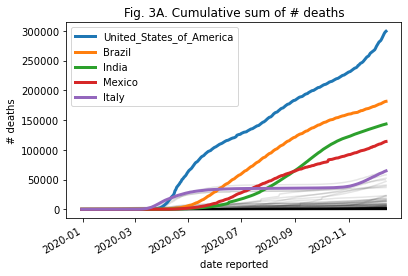

cumulative fractions by number of countries: cases_cs
0    0.23
1    0.37
2    0.46
3    0.50
4    0.53
Name: cases_cs, dtype: float64
cumulative fractions by number of countries: deaths_cs
0    0.19
1    0.30
2    0.39
3    0.46
4    0.50
Name: deaths_cs, dtype: float64


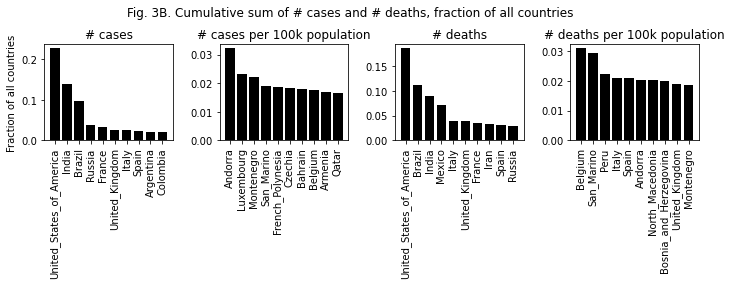

In [29]:
# cumulative sum of cases and deaths by date and country
df_tmp = df.copy()
df_tmp = df_tmp.set_index('dateRep').sort_index()
df_tmp['cases_cs'] = df_tmp.groupby('country')['cases'].cumsum()
df_tmp['deaths_cs'] = df_tmp.groupby('country')['deaths'].cumsum()
df_tmp['cases_cs_100k'] = df_tmp.groupby('country')['cases'].cumsum()/df_tmp['popData2019']*100000
df_tmp['deaths_cs_100k'] = df_tmp.groupby('country')['deaths'].cumsum()/df_tmp['popData2019']*100000

# countries with the largest cumsum # deaths
fig, ax = plt.subplots()
df_tmp.groupby('country')['deaths_cs'].plot(c='k', alpha=0.1, ax=ax)
for cc in df_tmp.groupby('country')['deaths_cs'].max().nlargest(5).index.to_list():
    ax.plot(df_tmp.groupby('country').get_group(cc)['deaths_cs'], lw=3, label=cc)
handles, labels = ax.get_legend_handles_labels()
handles = handles[-5:]
labels = labels[-5:]
ax.legend(handles, labels)
ax.set(title='Fig. 3A. Cumulative sum of # deaths', xlabel='date reported', ylabel='# deaths')
plt.show()
if savefig:
    fig.savefig(fig_path+'cumsum_deaths.pdf', bbox_inches='tight')

# fraction of world cumsum cases and deaths by country
fig, axs = plt.subplots(1,4, figsize=(10,4), sharey=False)
for ii, (xx, ax) in enumerate(zip(['cases_cs', 'cases_cs_100k', 'deaths_cs', 'deaths_cs_100k'], axs.flatten())):
    df_plot = df_tmp.groupby('country')[xx].max()
    df_plot = (df_plot/df_plot.sum()).nlargest(10).reset_index()
    ax.bar(x=df_plot['country'], height=df_plot[xx], color='k')
    ax.tick_params(axis='x', rotation=90)
    
    # top N countries give X% of worldwide count; summarized in Table 2 in the report
    if (xx=='cases_cs') | (xx=='deaths_cs'):
        print('cumulative fractions by number of countries:', xx) 
        print(df_plot[xx].cumsum()[:5].round(2))
    
axs[0].set(title='# cases', ylabel='Fraction of all countries')
axs[1].set_title('# cases per 100k population')
axs[2].set(title='# deaths')
axs[3].set_title('# deaths per 100k population')
fig.tight_layout()
plt.suptitle('Fig. 3B. Cumulative sum of # cases and # deaths, fraction of all countries')
plt.subplots_adjust(top=0.85)
plt.show()
if savefig:
    fig.savefig(fig_path+'fraction.pdf', bbox_inches='tight')

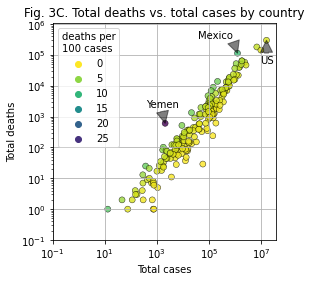

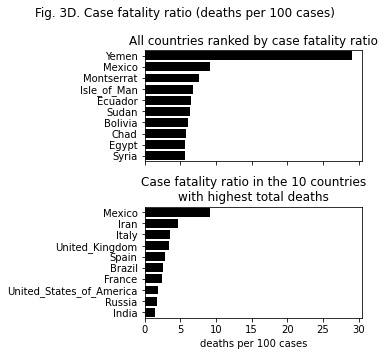

In [30]:
# countries with the most deaths
countries_most_death = df_tmp.groupby('country')['deaths_cs'].max().nlargest(10).index.to_list()
# deaths per 100 cases
df_plot = df_tmp.groupby('country')[['cases_cs', 'deaths_cs']].max()
df_plot['case_death_ratio'] = df_plot['deaths_cs']/df_plot['cases_cs']*100

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x='cases_cs', y='deaths_cs', data=df_plot, 
                hue='case_death_ratio', palette='viridis_r', ec='k', alpha=0.8, ax=ax)
ax.annotate('Mexico', xy=(df_plot.loc['Mexico', 'cases_cs'], 
                          df_plot.loc['Mexico', 'deaths_cs']),
            xytext=(df_plot.loc['Mexico', 'cases_cs']-4e5, 
                    df_plot.loc['Mexico', 'deaths_cs']+5e5), 
            arrowprops=dict(facecolor='black', alpha=0.5), 
            horizontalalignment='right', verticalalignment='top')
ax.annotate('US', xy=(df_plot.loc['United_States_of_America', 'cases_cs'], 
                      df_plot.loc['United_States_of_America', 'deaths_cs']), 
            xytext=(df_plot.loc['United_States_of_America', 'cases_cs'], 
                    df_plot.loc['United_States_of_America', 'deaths_cs']-2e5), 
            arrowprops=dict(facecolor='black', alpha=0.5), 
            horizontalalignment='center', verticalalignment='top')
ax.annotate('Yemen', xy=(df_plot.loc['Yemen', 'cases_cs'], 
                      df_plot.loc['Yemen', 'deaths_cs']), 
            xytext=(df_plot.loc['Yemen', 'cases_cs']-5e2, 
                    df_plot.loc['Yemen', 'deaths_cs']+3e3), 
            arrowprops=dict(facecolor='black', alpha=0.5), 
            horizontalalignment='center', verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.1, None])
ax.set_xlim([0.1, None])
ax.set(title='Fig. 3C. Total deaths vs. total cases by country', xlabel='Total cases', ylabel='Total deaths')
ax.legend(title='deaths per\n100 cases')
ax.grid()
plt.show()
if savefig:
    fig.savefig(fig_path+'death_case_ratio1.pdf', bbox_inches='tight')
    
fig, axs = plt.subplots(2,1, figsize=(5.25,5), sharex=True)
sns.barplot(x='case_death_ratio', y='country', 
            data=df_plot.reset_index().sort_values('case_death_ratio', ascending=False)[:10],
            color='k', ax=axs[0])
sns.barplot(x='case_death_ratio', y='country', 
            data=df_plot.reset_index()[df_plot.reset_index()['country']
                                       .isin(countries_most_death)].sort_values('case_death_ratio', ascending=False),
            color='k', ax=axs[1])
axs[0].set(title='All countries ranked by case fatality ratio', xlabel='', ylabel='')
axs[1].set(title='Case fatality ratio in the 10 countries\nwith highest total deaths', 
           xlabel='deaths per 100 cases', ylabel='')
plt.suptitle('Fig. 3D. Case fatality ratio (deaths per 100 cases)')
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'death_case_ratio2.pdf', bbox_inches='tight')

In [31]:
# df of rank by population, total deaths, and total death rate per 100k population
df_rank = df_tmp.groupby('country')['popData2019'].max().rank(ascending=False).astype(int).to_frame()#.reset_index()
df_rank['case_rate'] = df_tmp.groupby('country')['cases_cs_100k'].max().rank(ascending=False).astype(int)
df_rank['cases'] = df_tmp.groupby('country')['cases_cs'].max().rank(ascending=False).astype(int)
df_rank['death_rate'] = df_tmp.groupby('country')['deaths_cs_100k'].max().rank(ascending=False).astype(int)
df_rank['deaths'] = df_tmp.groupby('country')['deaths_cs'].max().rank(ascending=False).astype(int)

# countries with top 30 case rate and death rate
df_rank[(df_rank['case_rate']<=30) & (df_rank['death_rate']<=30)]\
.sort_values(by='popData2019').reset_index()#.to_csv('rank.csv')

,country,popData2019,case_rate,cases,death_rate,deaths
0,United_States_of_America,3,11,1,12,1
1,France,21,25,5,15,7
2,Spain,30,22,8,5,9
3,Belgium,80,8,21,1,18
4,Czechia,86,6,22,13,27
5,Panama,125,15,42,21,46
6,Croatia,127,17,48,30,50
7,Armenia,134,9,53,17,55
8,Slovenia,145,14,73,27,71
9,North_Macedonia,146,27,85,7,60


### Analysis: Which countries have the highest 14-day cumsum cases per 100k population? <br>How do they compare with countries with the largest populations?

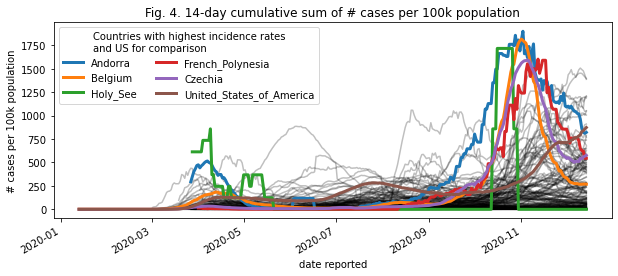

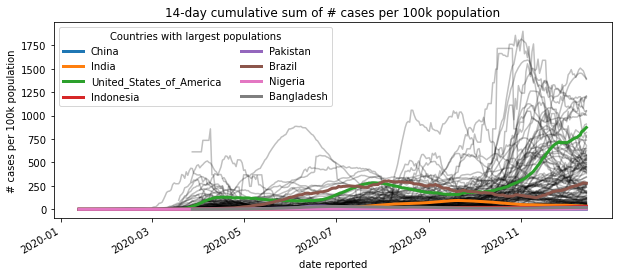

In [32]:
# data exploration: countries with the largest 14-day cumsum cases 
# plus US for comparison
high_cumsum = df.groupby('country')['cases_cumsum14_100k'].max().nlargest(5).index.to_list()
high_cumsum.append('United_States_of_America')
df_tmp = df.copy().set_index('dateRep')
fig, ax = plt.subplots(figsize=(10,4))
df_tmp.groupby('country')['cases_cumsum14_100k'].plot(c='k', alpha=0.25, ax=ax)
ax.set(title='Fig. 4. 14-day cumulative sum of # cases per 100k population', 
       ylabel='# cases per 100k population', xlabel='date reported')
for cc in high_cumsum:
   ax.plot(df_tmp.groupby('country').get_group(cc)['cases_cumsum14_100k'], lw=3, label=cc)
handles, labels = ax.get_legend_handles_labels()
handles = handles[-len(high_cumsum):]
labels = labels[-len(high_cumsum):]
ax.legend(handles, labels, title='Countries with highest incidence rates\nand US for comparison', ncol=2)
plt.show()
if savefig:
    fig.savefig(fig_path+'high_cumsum.pdf', bbox_inches='tight')

# data exploration: 14-day cumsum cases for countries with the largest population
high_pop = df.groupby('country')['popData2019'].max().nlargest(8).index.to_list()
df_tmp = df.copy().set_index('dateRep')
fig, ax = plt.subplots(figsize=(10,4))
df_tmp.groupby('country')['cases_cumsum14_100k'].plot(c='k', alpha=0.25, ax=ax)
ax.set(title='14-day cumulative sum of # cases per 100k population', 
       ylabel='# cases per 100k population', xlabel='date reported')
for cc in high_pop:
   ax.plot(df_tmp.groupby('country').get_group(cc)['cases_cumsum14_100k'], lw=3, label=cc)
handles, labels = ax.get_legend_handles_labels()
handles = handles[-len(high_pop):]
labels = labels[-len(high_pop):]
ax.legend(handles, labels, title='Countries with largest populations', ncol=2)
plt.show()